In [12]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import omidb
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import pydicom
import yaml

# Dataset analysis

     The dataset folder is being mounted to padel from mia server.

To start we want to create a db object that contains all the clients found in the omi-db path. <br>
The second step is to create a list of all the clients that are in the omi-db path. <br>

In [2]:
#define the path to the dataset
reading_path = '/mnt/mia_images/breast/omi-db/image_db/sharing/omi-db/'
# db = omidb.DB(reading_path, clients=['demd1', 'demd116'])
db = omidb.DB(reading_path, clients=['demd100018', 'demd128247', 'demd843','demd94678'])
#save clients in a list
clients = [client for client in db]
#The number of clients/petients
len(clients)

4

## Structure of the OMI-DB dataset object

A <ins> **client** </ins>. represents a patient and can have one or more episodes. <br>
    
- The client object gives information about the client such as:
    - The client id
    - A list of episodes
    - The site (hospital) name
    - The client's status (benign, malignant, normal, interval cancer)

Let's take a client exmaple and analyze it:

In [1]:
client_num = 0
#get a client
client_ex = clients[client_num]
print(f'The client id is: {client_ex.id}')
print(f'The client number of episodes is: {len(client_ex.episodes)}')
print(f'The name of the site is: {client_ex.site.value}')
print(f'The client status is: {client_ex.status.value}')

The next interesting object is the episode <ins> **object** </ins>. <br>
Episodes contain a set of medical procedures or events associated with the treatment or diagnosis. <br>
- The episode object contains:
    - The episode id (unique for within client)
    - Events object: a set of medical procedures or events associated wiith the episode
    - Studies list: studies are collections of screening and diagnostic images
    

In [332]:
episode_num = 0
#Get the first episode of the client as example
episode_ex = client_ex.episodes[episode_num]
#get id of the episode
print(f'The episode id is: {episode_ex.id}')
print(f'The number of studies is: {len(episode_ex.studies)}') if episode_ex.studies else print('No studies')
print(f'The episode type is: {episode_ex.type.value}')
print(f'The episode action is: {episode_ex.action.value}')
print(f'The episode opened date is: {episode_ex.opened_date}')
print(f'The episode closed date is: {episode_ex.closed_date}')
print(f'is the episode closed?: {episode_ex.is_closed}')
print(f'number of lesions in the episode: {len(episode_ex.lesions)}') if episode_ex.lesions else print('No lesions')

# Addiitioanl properties can be given back:
print(f'The episode has benign opinions?: {episode_ex.has_benign_opinions}')
print(f'The episode has malignant opinions?: {episode_ex.has_malignant_opinions}')
#print seperator
print('-----------------------------')
# Get the events object, it shows all the events that happened in the episode
events_ex = episode_ex.events
# print(f'All the events in the episode: \n{events_ex}')
# print(events_ex)


The episode id is: 9999
The number of studies is: 2
The episode type is: First Call
The episode action is: Follow-up (Post-treatment)
The episode opened date is: 2009-08-26
The episode closed date is: 2010-04-29
is the episode closed?: True
No lesions
The episode has benign opinions?: False
The episode has malignant opinions?: True
-----------------------------


The next structure could are <ins> **events** </ins> and <ins> **studies** </ins>. <br>
Studies are imaging examinations made out of <ins>series</ins>. Each serie contains a set of <ins> **images** </ins>. <br>

    Note that not all episodes may have studies!!
This is important to consider, as we care about the episodes that have images (therefore, studies). <br>

In [333]:
# Get the first study of the episode as example
study_num = 0
if episode_ex.studies:
    study_ex = episode_ex.studies[study_num]
    print(f'The study id is: {study_ex.id}')
    print(f'The number of series is: {len(study_ex.series)}')
    print(f'The event type(s) is: {study_ex.event_type}')
    print(f'The study date is: {study_ex.date}')

else:
    print('No studies')

The study id is: 1.2.826.0.1.3680043.9.3218.1.1.2807438.9038.1510340992050.2856.0
The number of series is: 2
The event type(s) is: [<Event.screening: 'screening'>]
The study date is: 2009-10-14


Series are the next and final subsrtucture of the dataset. <br>
It is a <ins> **collection of images** </ins> taken during one examination by one modality, for a given position of the patient in the acquisition device. <br>
In full-field digital mammography, each image is usually associated with one series. <br>
- The series object contains:
    - The series id
    - The list of images

The series id is: 1.2.826.0.1.3680043.9.3218.1.1.2807438.9038.1510340992050.2862.0
The number of images is: 4
The list of marks in the image is: [Mark(id='3156', lesion_id='1', boundingBox=BoundingBox(x1=1019, y1=1625, x2=1532, y2=1918), conspicuity=<Conspicuity.obvious: 'Obvious'>, architectural_distortion=None, dystrophic_calcification=None, fat_necrosis=None, focal_asymmetry=None, mass=None, suspicious_calcifications=True, milk_of_calcium=None, other_benign_cluster=None, plasma_cell_mastitis=None, benign_skin_feature=None, calcifications=None, suture_calcification=None, vascular_feature=None, benign_classification=None, mass_classification=None)]


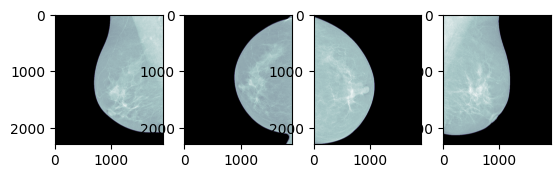

In [341]:
# Get the first series of the study as example
series_num = 1
series_ex = study_ex.series[series_num]
print(f'The series id is: {series_ex.id}')
print(f'The number of images is: {series_ex.num_images}')
#All images in the series can be plotted using
series_ex.plot()
print(f'The list of marks in the image is: {series_ex.images[0].marks}')

The images are the elemental elements of the dataset (from the point of view of our analysis). <br>
Image objects contain all the relevant information about the image. <br>

- The image object contains:
    - The image id: unique for each image
    - Dicom path
    - JSON file path with the DICOM metadata
    - A dictionary containing the DICOM metadata
    - A parsed version of the DICOM file

In [339]:
image_num = 0 # usually there is just one image in the series
# get the first image of the series as example
image_ex = series_ex.images[image_num]

print(f'The image id is: {image_ex.id}')
print(f'The dicom path is: {image_ex.dcm_path}')
print(f'The JSON path is: {image_ex.json_path}')
print(f'The list of marks in the image is: {image_ex.marks}')

The image id is: 1.2.826.0.1.3680043.9.3218.1.1.2807438.9038.1510340992050.2865.0
The dicom path is: /mnt/mia_images/breast/omi-db/image_db/sharing/omi-db/images/demd268/1.2.826.0.1.3680043.9.3218.1.1.2807438.9038.1510340992050.2856.0/1.2.826.0.1.3680043.9.3218.1.1.2807438.9038.1510340992050.2865.0.dcm
The JSON path is: /mnt/mia_images/breast/omi-db/image_db/sharing/omi-db/data/demd268/1.2.826.0.1.3680043.9.3218.1.1.2807438.9038.1510340992050.2856.0/1.2.826.0.1.3680043.9.3218.1.1.2807438.9038.1510340992050.2865.0.json
The list of marks in the image is: [Mark(id='3156', lesion_id='1', boundingBox=BoundingBox(x1=1019, y1=1625, x2=1532, y2=1918), conspicuity=<Conspicuity.obvious: 'Obvious'>, architectural_distortion=None, dystrophic_calcification=None, fat_necrosis=None, focal_asymmetry=None, mass=None, suspicious_calcifications=True, milk_of_calcium=None, other_benign_cluster=None, plasma_cell_mastitis=None, benign_skin_feature=None, calcifications=None, suture_calcification=None, vascul

# Construction of the dataset

## Functions

In [3]:
class stats:
    """Class for keeping track of the statistics of the dataset
    """
    def __init__(self, N:int, B:int, M:int, IC:int):
        """Initialize the statistics object

        Args:
            N (int): Normal client status
            B (int): Bening client status
            M (int): Malignant client status
            IC (int): Interval Cancer client status
        """
        self.N = N
        self.M = M
        self.B = B
        self.IC = IC # not present
        self.image_CC = 0
        self.image_MLO = 0
        self.image_R = 0
        self.image_L = 0
        self.subtype = np.zeros(8, dtype=np.int32)

    def __repr__(self):
        """when printing the object, print the following:

        Returns:
            str: description of the statistics
        """
        return \
            f'Stats [N: {self.N}, M {self.M}, B: {self.B}, IC {self.IC},'\
            f'CC: {self.image_CC}, MLO: {self.image_MLO}, '\
            f'R: {self.image_R}, L:{self.image_L}, ' \
            f'Subtype: {np.array2string(self.subtype)} ]'

def update_stats_patient(overall:stats, client):

    # Save the general pathological status of the patient:
    #   M: malignant, N:Normal, CI: Interval Cancer
    # In the API, the label is given in the following order of importance:
    # CI > M > B > N
    if client.status.value == 'Interval Cancer': # not present
        overall.IC += 1
    elif client.status.value == 'Malignant':
        overall.M += 1
    elif client.status.value == 'Benign':
        overall.B += 1
    elif client.status.value == 'Normal':
        overall.N += 1
    return overall

In [23]:
def check_tag_and_value(json_data:dict, tag:str):
    """returns true if the tag is in the json file and has value

    Args:
        json_data (dict): json object with the data
        tag (str): DICOM tag

    Returns:
        bool: true if the tag is in the json file and has value
    """
    return (tag in json_data) and ('Value' in json_data[tag])

def check_presence(json_data:dict):
    """checks if the json file has the required fields

    Args:
        json_data (dict): jason object with the data

    Returns:
        bool: true if the json file has the required fields
    """
    # criteria for selecting images
    for_pres = json_data['00080068']['Value'][0] == 'FOR PRESENTATION' # only images for presentation
    series_descrip = check_tag_and_value(json_data, '0008103E') # check if the series description (side view or other) is defined and has value
    manufacturer = check_tag_and_value(json_data, '00080070') # check if the manufacturer is defined and has value
    fov_type = check_tag_and_value(json_data, '00191039') # check if the fov_type is defined and has value

    if for_pres and (not fov_type): #and series_descrip and manufacturer: # if all the criteria are met, return True
        return True
    else:
        return False

def json_tag2value(json_data:dict, tag:str):
    """returns the value of the tag in the json file

    Args:
        json_data (dict): json object with the data
        tag (str): DICOM tag

    Returns:
        str: value of the tag or None
    """
    if check_tag_and_value(json_data, tag):
        return json_data[tag]['Value'][0]
    else:
        return None

## Dataset metadata

In [2]:
#define the path to the dataset
reading_path = '/mnt/mia_images/breast/omi-db/image_db/sharing/omi-db/'
# db = omidb.DB(reading_path, clients=['demd100018', 'demd128247', 'demd843','demd94678'])
db = omidb.DB(reading_path)

NBSS data is **client level** information stored in a dictionary, containing:
- The client id
- The episodes id (one key per episode)
- The classification veredict ()

### Keeping some visual help

In [154]:
# create dataframe storing path, presentation type, side, manufacturer, view
df = None

# Initialize the statistics object
overall = stats(0, 0, 0, 0)
for client in tqdm(db, total=len(db.clients)):          # client level
    overall = update_stats_patient(overall, client) # extract the client status for statistics
    nbss_data = db._nbss(client.id) # store nbss data of the client
    # print('=====================================')
    # print(f'Client: {client.id}')
    for episode in client.episodes:                     # episode level
        if episode.studies is not None: # only if the episode has studies
            # print('---------------------------------')
            # print(f'Episode {episode.id}')
            # print('---------------------------------')
            # Episodes may have multiple studies
            # episode_data = nbss_data.get(episode.id, None) # get the nbss data of the episode
            # for key, value in episode_data.items():
            #     if key in ['BIOPSYWIDE', 'SURGERY', 'SCREENING', 'ASSESSMENT']: # for each main information type
            #         for sides_keys, sides_values in value.items(): # inside each of this main information type
            #             if sides_keys=='R' or sides_keys=='L': # if the sides are well defined
            #                 side = sides_keys # define the side
            #                 print(side)
            for study in episode.studies:
                # print('//////////////')
                # print(f'Study {study.event_type}')
                for series in study.series:
                    # print('*************')
                    # print(f'Series {series}')
                    for image in series.images:
                        # print('##############')
                        # add information of current image to dataframe using concat
                        with open(image.json_path, 'r') as f: # open the json file
                            json_data = json.load(f)
                        df = pd.concat(
                            [df, pd.DataFrame(
                            {
                                'client_id': client.id,
                                'episode_id': episode.id,
                                'study_id': study.id,
                                'series_id': series.id,
                                'image_id': image.id,
                                'path': image.dcm_path,
                                'json_path': image.json_path,
                                'presentation': json_data['00080068']['Value'][0],
                                'side': json_data['0008103E']['Value'][0].split(' ')[0],
                                'manufacturer': json_data['00080070']['Value'][0],
                                'view': json_data['0008103E']['Value'][0].split(' ')[1],
                                'magnification': json_data['00191039']['Value'][0] if '00191039' in json_data else None,
                            }, index=[0])], axis=0)
# save the dataframe
df.to_csv('metadata.csv', index=False)

100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


In [156]:
# open dataframe
df = pd.read_csv('metadata.csv')
# filter by presentation
df = df[df['presentation']=='FOR PRESENTATION']
df.json_path[0]

'/mnt/mia_images/breast/omi-db/image_db/sharing/omi-db/data/demd128247/1.2.826.0.1.3680043.9.3218.1.1.242302667.45008.1546430561995.2.0/1.2.826.0.1.3680043.9.3218.1.1.242302667.45008.1546430561995.5.0.dcm.json'

/mnt/mia_images/breast/omi-db/image_db/sharing/omi-db/images/demd128247/1.2.826.0.1.3680043.9.3218.1.1.242302667.4500.1546430561995.53.0/1.2.826.0.1.3680043.9.3218.1.1.242302667.4500.1546430561995.63.0.dcm
/mnt/mia_images/breast/omi-db/image_db/sharing/omi-db/images/demd128247/1.2.826.0.1.3680043.9.3218.1.1.242302667.4500.1546430561995.53.0/1.2.826.0.1.3680043.9.3218.1.1.242302667.4500.1546430561995.66.0.dcm


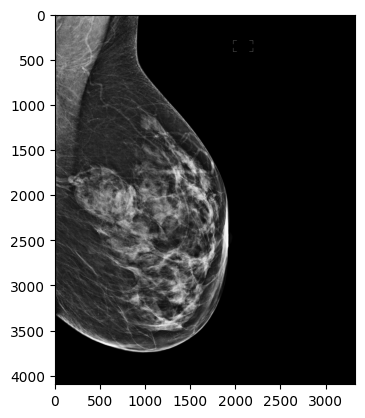

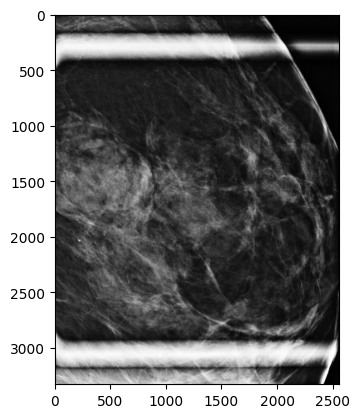

In [190]:
# open dataframe
df = pd.read_csv('metadata.csv')
# filter by presentation
df = df[df['presentation']=='FOR PRESENTATION']
# filter by side
df = df[df['view']=='LM']
for path in df.path:
    # open the dicom file
    print(path)
    dcm = pydicom.dcmread(path)
    # get the image
    image = dcm.pixel_array
    # plot the image
    plt.figure()
    plt.imshow(image, cmap='gray')

### CSV of *for presentation* images

In [30]:
# create dataframe storing path, presentation type, side, manufacturer, view
df = None
empty_json = 0

# read dicom tags yaml
with open('metadata/dicom_tags.yaml', 'r') as file:
    tags = yaml.load(file, Loader=yaml.FullLoader)

# Initialize the statistics object
overall = stats(0, 0, 0, 0)
for client in tqdm(db, total=len(db.clients)):          #@ client level
    overall = update_stats_patient(overall, client) # extract the client status for statistics
    nbss_data = db._nbss(client.id) # store nbss data of the client
    for episode in client.episodes:                     #@ episode level
        if episode.studies is not None: # only if the episode has studies
            for study in episode.studies:               #@ study level
                for series in study.series:             #@ series level
                    for image in series.images:         #@ image level
                        with open(image.json_path, 'r') as file: # open the image json file
                            if file.read() != '': # check the file is not empty
                                file.seek(0) # go back to the beginning of the file
                                json_data = json.load(file)
                            else:
                                empty_json += 1
                        # check if the json file has the relevant information
                        if check_presence(json_data): # if the image is for presentation
                            # object oriented information storage
                            df_sub = pd.DataFrame(
                                {
                                    'client_id': client.id,
                                    'episode_id': episode.id,
                                    'study_id': study.id,
                                    'series_id': series.id,
                                    'image_id': image.id,
                                    'path': image.dcm_path,
                                    'json_path': image.json_path,
                                    'client_status': client.status.value,
                                }, index=[0])
                            # go through the tags and save the json-contained information
                            for tag in tags:
                                df_sub = pd.concat([df_sub, pd.DataFrame({tag: json_tag2value(json_data, tags[tag])}, index=[0])], axis=1)
                            # concat in general df
                            df = pd.concat(
                                [df, df_sub], axis=0)                        

# save the dataframe
df.to_csv('metadata/metadata_FP.csv', index=False)

# print the statistics
subclients_num =  len(df['client_id'].unique())
print(f'Number of valid clients: {subclients_num}')
print(f'Images with no valid json file: {empty_json}')

 24%|██▍       | 1454/6000 [09:09<28:37,  2.65it/s]  

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/home/ricardo/miniconda3/envs/iceberg/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1223254/3938743672.py", line -1, in <module>
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ricardo/miniconda3/envs/iceberg/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/ricardo/miniconda3/envs/iceberg/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1118, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/ricardo/miniconda3/envs/iceberg/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1012, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/home/ricardo/miniconda3/envs

The whole dataset size.